In [3]:
import numpy as np
import torch
import copy
from torch import nn
from torch import optim
import torch.nn.functional as F
import torchvision
from torchvision import datasets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

In [4]:
datasets_path = "~/datasets"

with_cuda = torch.cuda.is_available()
if with_cuda:
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

# Reminders on a toy dataset

## Building the dataset

In [5]:
def generate_image(height, width):
    img = torch.zeros((1, height, width), device = device)
    j_pos = torch.randint(2, width - 2, (1,))
    for i in range(height):
        for j in range(j_pos - 2, j_pos + 2):
            img[0, i, j] = 1
    cl = torch.randint(0, 4, (1,)).item()
    img = transforms.functional.rotate(img, 45*cl)
    return img, cl


**Question 1**

With the class `torch.utils.data.TensorDataset`, build a dataset generated by the function `generate_image`. Show some samples with matplotlib functiob `imshow`.

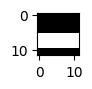

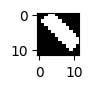

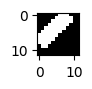

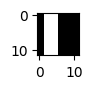

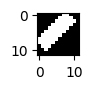

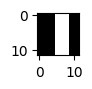

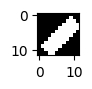

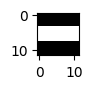

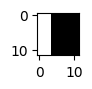

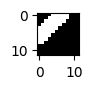

In [6]:
N = 1000
Liste = [(0,0)]*N 
images = [0]*N
labels = [0]*N
for i in range(0, N): 
    Liste[i]= generate_image(12, 12)
    images[i]=Liste[i][0]
    labels[i]=Liste[i][1]

images= torch.stack(images, dim=0)
labels = torch.LongTensor(labels)


#la dimension de images (Tensor de taille n*channels*heigth*width)
#ici 1000*1(niveaux de gris)*12*12
#labels : Tensor d'ordre n avec des entiers (long tensor)

dataset = torch.utils.data.TensorDataset(images, labels)
trainloader = torch.utils.data.DataLoader(dataset, batch_size=128, shuffle=True, drop_last=True)

for i in range (1, 11):
    plt.subplot(1, 10, i)
    plt.imshow(images[i].squeeze(), cmap = "gray") #supprime les dimensions égales à 1 (channel)
    plt.show()


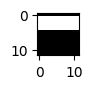

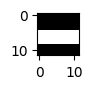

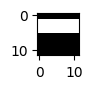

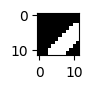

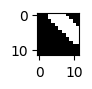

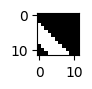

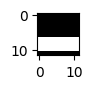

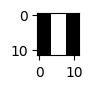

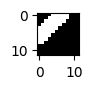

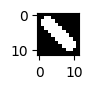

In [7]:
#Correction
n = 1000
height = 12
width = 12

images = torch.zeros(n, 1, height, width, device = device)
classes = torch.LongTensor(n).to(device)

for i in range(n):
    images[i], classes[i] = generate_image(height, width)

dataset = torch.utils.data.TensorDataset(images, classes)
for i in range (1, 11):
    plt.subplot(1, 10, i)
    plt.imshow(images[i].squeeze(), cmap = "gray") #supprime les dimensions égales à 1 (channel)
    plt.show()


**Question 2**

Put the dataset into a `DataLoader`. What are the differences between a dataset and a data loader?

In [7]:
data_loader = torch.utils.data.DataLoader(dataset, batch_size=128, shuffle=True, drop_last=True)

What are Conv2d, Linear and MaxPool?

Con2d --> Idée : les masques représentent la reconnaissance d'un **motif local dans l'image**, quand il rencontre le même motif sur l'image, on a un pixel qui va être de grande valeur et inversement, si le motif n'est pas reconnu, le pixel renvoyé sera d'une plus faible valeur. Les réseaux de neurones convolutionnels fonctionnent en **local**, c'est pour ça qu'ils sont efficaces pour les images naturelles. \
Quand on empile les couches de convolutions, on considère des éléments étendus dans l'image pour vu de faire des masques plus grands, ou que l'on empile plusieurs couches. \
Une couche FC serait mieux mais il y a trop de paramètres et ce ne sera pas de l'information locale. \
C'est uniquement pour un canal de sortie et un canal d'entrée (donc il faut multiplier l'opération par le nombre de canaux d'entrée et de sortie). \
**Idée générale** : commencer par 3 canaux (RGB), et augmenter le nombre de canaux (jusqu'à 64) et le mettre dans une couche FC.

In a dataset, the elements can be accessed individually given an index (with `[i]`). 

A data loader is an `Iterable`, which means that its elements can only be accessed through an `Iterator` that traverses the dataset in a way that is provided by the arguments of the data loader (batch size, random/deterministic choice of the data points, etc.). In particular, it can be traversed with a `for` loop.

## Simple NN/training

**Question 3**

Write a neural network that classifies the data points previously generated. One can use a convolutional and a fully-connected layer.

What are the parameters of a convolutional layer? What is their shape?

In [12]:
class SmallCVNN(nn.Module):
    def __init__(self):
        super(SmallCVNN, self).__init__()

        self.act_function = torch.relu
        layer = [1, 6, 4]

        self.conv1 = torch.nn.Conv2d(layer[0], layer[1], 5)
        self.fc = torch.nn.Linear(4*4*layer[1], layer[2])

    def forward(self, x):
        x = x.view(x.size(0),-1)
        x = self.conv1(x)
        x = self.act_function(x)
        x = torch.nn.functional.max_pool2d(x, 2)

        x = x.view(x.size(0),-1)
        x = self.fc(x)
        x = torch.nn.functional.log_softmax(x, dim = 1)

        return x
    

Parameters: `conv.bias`, `conv.weight`.

`conv.bias`: size `out_channels`

`conv.weight`: size `out_channels` * `in_channels` * `kernel_height` * `kernel_width`

In [13]:
def train_model(model, criterion, optimizer, nepochs):
    #List to store loss to visualize
    train_losses = []
    train_acc = []
    start_epoch = 0

    for epoch in range(start_epoch, nepochs):
        train_loss = 0.
        valid_loss = 0.
        correct = 0

        model.train()
        for batch_idx, (data, target) in enumerate(data_loader):
            # clear the gradients of all optimized variables
            optimizer.zero_grad()

            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)

            # calculate the batch loss
            loss = criterion(output, target)

            # backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()

            # perform a single optimization step (parameter update)
            optimizer.step()

            # update training loss
            train_loss += loss.item() * data.size(0)
            
            # accuracy
            pred = output.data.max(1, keepdim=True)[1]
            correct += pred.eq(target.data.view_as(pred)).sum().item()

        # calculate average losses
        train_loss = train_loss/len(data_loader.dataset)
        accuracy = correct/len(data_loader.dataset)*100
        train_acc.append(accuracy)
        train_losses.append(train_loss)

        # print losses statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tTraining accuracy: {:.6f}'.format(
            epoch, train_loss, accuracy))

**Question 4**

Choose the loss and train the NN. Why do we choose to minimize the loss instead of maximizing the accuracy?

In [15]:
model = SmallCVNN()

# loss function
criterion = nn.CrossEntropyLoss()

# optimizer
optimizer = optim.Adam(model.parameters())

nepochs = 10

train_model(model, criterion, optimizer, nepochs)

RuntimeError: Expected 3D (unbatched) or 4D (batched) input to conv2d, but got input of size: [128, 144]

The derivative of the accuracy w.r.t. the parameters of the NN is zero, so the NN cannot be trained with this "loss".

# Variational Auto-Encoders (VAE): MNIST and FashionMNIST

## Building a standard fully-connected VAE

**Question 1**

Complete the class `VAE_FC`:
 * build an encoder module;
 * build a decoder module;
 * write the method `encode`, which takes an input `x` and returns means and log-variances;
 * write the method `decode`, which takes a random variable `z` and returns the reconstructed image;
 * write the method `reparameterization`, taking means and variances and returning normal samples with these means and variances;
 * write the method `forward`, which takes an input `x` and returns its reconstruction `x_hat`, and the mean/variance of the latent representation.

Additionally:
 * write the method `sample`, which generates new data;
 * write the method `reconstruct`, which attempts to reconstruct the input.

In [16]:
batch_size = 128
#mean, std = .2860, .3530

# build transform
transform = transforms.Compose([
    transforms.ToTensor(),
    ]) 

# choose the training and test datasets
train_data = datasets.MNIST(datasets_path, train = True,
                              download = True, transform = transform)
test_data = datasets.MNIST(datasets_path, train=False,
                             download = True, transform = transform)

train_size = len(train_data)
test_size = len(test_data)

# build the data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size = batch_size)
test_loader = torch.utils.data.DataLoader(test_data, batch_size = batch_size, shuffle = False)

# specify the image classes
classes = [f"{i}" for i in range(10)]

In [ ]:
#layers: liste de tailles de couches (encoder)
k = 2
layers = [784, 784//k, 784//(2*k), 784//(3*k)]
lst = [nn.Linear(layers[i], layers[i+1]) for i in range (len(layers)-1)]
lst2 = [[lst[i//2] for i in range(len(layers)-1)] if i%2 == 0 else nn.ReLU()]


class VAE_FC(nn.Module):
    def __init__(self, layers, latent_dim = 200, leak = .1):
        super(VAE_FC, self).__init__()
        self.layers = layers
        self.latent_dim = latent_dim
        layers = [0, 0, 0]
        #encoder
        encoder = []
        for l_in, l_out in zip[layers[:-1], layers[:1]]:
            encoder +=(nn.Linear(l_in, l_out), nn.LeakyReLU(leak))
        self.encoder = nn.Sequential(*encoder) #* permet de dérouler la liste, c'est comme si on écrivait encoder[0], ecnoder[1]...
    
        self.fc_mean = nn.Linear(layers[-1], latent_dim)
        self.logvar = nn.Linear(layers[-1], latent_dim)
        #couches FC qui prennent qlqc sortie de l'encoder et sortent qlqc qui est dans l'espace latent 
        #mêmes structures mais entraînées de manières différentes (cf cours avec l'ELBO et KL(latent_space_dist, prior))

        self.decoder_input = nn.Linear(latent_dim, layers[-1])

        rev_layers = list(reversed(layers))
        decoder = [nn.LeakyReLU(leak)]
        for l_in, l_out in zip[rev_layers[:-1], rev_layers[:1]]:
            decoder +=(nn.Linear(l_in, l_out), nn.LeakyReLU(leak))
        decoder += [nn.Linear(layers[1], layers[0]), nn.Sigmoid()]
        self.decoder = nn.Sequential(*decoder) 
 

    

    def encode(self, x):
        x = self.encoder(x)
        
    def reparameterization(self, mean, logvar):
        epsilon = torch.normal(0, 1)
        self = mean**2 + torch.mul(logvar, epsilon[1]) 


    def decode(self, x):
        x = self.decoder()
       
    def forward(self, inputs): 
        layers = [0, 0, 0]
        latent_dim = 0   
        self.fc_mean = nn.Linear(layers[-1], latent_dim)
        self.fc_logvar = nn.Linear(layers[-1], latent_dim)
        
    
    def sample(self, num_samples): #inférence, pas besoin de tirer qlqc d'aléatoire
        pass
    
    def reconstruct(self, x): #reconstruction à paartir d'un input
        pass

**Question 2**

Write the function `build_loss_vae`, which builds the loss function for the VAE. The reconstruction loss and the KL loss will be balanced by two parameters `lambda_reconstruct` and `lambda_kl` (by default, they are equal to 0.5).

In [ ]:
def build_loss_vae():
    

## Training

In [ ]:
def train_model_vae(data_loader, model, criterion, optimizer, nepochs):
    #List to store loss to visualize
    train_losses = []
    train_acc = []
    start_epoch = 0

    for epoch in range(start_epoch, nepochs):
        train_loss = 0.
        valid_loss = 0.
        correct = 0

        model.train()
        for batch_idx, (input_, target) in enumerate(data_loader):
            input_ = input_.to(device)
            # clear the gradients of all optimized variables
            optimizer.zero_grad()

            # forward pass: compute predicted outputs by passing inputs to the model
            # ...

            # calculate the batch loss
            # ...

            # backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()

            # perform a single optimization step (parameter update)
            optimizer.step()

            # update training loss
            train_loss += loss.item() * input_.size(0)

        # calculate average losses
        train_loss = train_loss/len(data_loader.dataset)
        train_losses.append(train_loss)

        # print losses statistics 
        print('Epoch: {} \tTraining Loss: {:.6f}'.format(
            epoch, train_loss))

**Question 3**

Train the VAE on MNIST or FashionMNIST. Don't forget to save it!

**Question 4**

With the resulting model:
 * show some generated samples;
 * check the quality of the reconstruction;
 * show some interpolations between images.

## Conditional VAE

**Question 5**

Modify the VAE to build a conditional VAE:
 * the input vectors should be enriched with a one-hot vector coding for the class;
 * went sent to the decoder, the latent representation should be enriched with a one-hot vector coding for the class.

Modify also the function `train_model_vae`.

In [ ]:
def train_model_vae(data_loader, model, criterion, optimizer, nepochs, cond = False):
    #List to store loss to visualize
    train_losses = []
    train_acc = []
    start_epoch = 0

    for epoch in range(start_epoch, nepochs):
        train_loss = 0.
        valid_loss = 0.
        correct = 0

        model.train()
        for batch_idx, (input_, target) in enumerate(data_loader):
            input_ = input_.to(device)
            target = target.to(device)
            # clear the gradients of all optimized variables
            optimizer.zero_grad()

            # forward pass: compute predicted outputs by passing inputs to the model
            if cond:
                # ...
            else:
                # ...

            # calculate the batch loss
            loss = criterion(input_, output_, mean, logvar)

            # backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()

            # perform a single optimization step (parameter update)
            optimizer.step()

            # update training loss
            train_loss += loss.item() * input_.size(0)

        # calculate average losses
        train_loss = train_loss/len(data_loader.dataset)
        train_losses.append(train_loss)

        # print losses statistics 
        print('Epoch: {} \tTraining Loss: {:.6f}'.format(
            epoch, train_loss))

IndentationError: expected an indented block after 'if' statement on line 20 (2948407004.py, line 22)

**Question 6**

Train the model.

With the resulting model:
 * show some generated samples;
 * check the quality of the reconstruction;
 * show some interpolations between images.

# Variational inference

The goal is to build a variational inference (VI) model. We will use the family of independent Gaussian distributions, which means that each parameter $\theta_k$ of the model will be randomly generated w.r.t. a Gaussian distribution $\mathcal{N}(\mu_k, \sigma_k^2)$. The parameters to be learned are the $(\mu_1, \sigma_1^2, \cdots, \mu_p, \sigma_p^2)$.

To simplify, we will work with a multilayer perceptron. For each pass trhough the model, we will generate randomly the weights and the biases w.r.t. their own Gaussian distribution.

In [ ]:
batch_size = 128
#mean, std = .2860, .3530

# build transform
transform = transforms.Compose([
    transforms.ToTensor(),
    ]) 

# choose the training and test datasets
train_data = datasets.MNIST(datasets_path, train = True,
                              download = True, transform = transform)
test_data = datasets.MNIST(datasets_path, train=False,
                             download = True, transform = transform)

train_size = len(train_data)
test_size = len(test_data)

# build the data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size = batch_size)
test_loader = torch.utils.data.DataLoader(test_data, batch_size = batch_size, shuffle = False)

# specify the image classes
classes = [f"{i}" for i in range(10)]

**Question 1**

Build a `Module` named `LinearVI` that is similar to the `Linear` layer, but contains the means and variances of the independent Gaussian distributions generating the weights and the biases:
* the log-variances will be stored instead the variances themselves;
* the means/log-variances should be implemented both for the weights and the biases;
* the `forward` method should be implemented: it is recommended to start with generating Gaussian noise, and then translate and scale it to obtain the weights and biases; one can use the function `F.Linear` to compute the output;
* the attributes `weight_prior_logvar` and `bias_prior_logvar` contain the initialization log-variance for the weighs and for the biases.

In [ ]:
class LinearVI(nn.Module):
    def __init__(self, ...):
        
        ...
        
        self.weight_prior_logvar = np.log(1 / n_in)
        self.bias_prior_logvar = np.log(.01)
        
        ...
        
    def forward(self, x):
        ...

**Question 2**

Build a multilayer perceptron `PerceptronVI` made of fully-connected variational layers (`LinearVI`).

In [ ]:
class PerceptronVI(torch.nn.Module):
    def __init__(self, ...):
        ...

    def forward(self, x):
        ...
    

**Question 3**

Complete the train function below. The `loss_kl` is defined as:
$$
L(\boldsymbol{\theta}) = \lambda \sum_{k = 1}^p \left[ \frac{1}{2} \log\left(\frac{\sigma_{0k}^2}{\sigma_k^2}\right) +\frac{\sigma_k^2 + \mu_k^2}{2 \sigma_{0k}^2} + \frac{1}{2}\right] ,
$$
where $\sigma_{0k}^2$ is the variance of the prior distribution on $\theta_k$ (defined for each layer via `weight_prior_logvar` and `bias_prior_logvar`) and $\lambda$ is the penalty factor `pen_factor`.

It is recommended to add new methods to `LinearVI` and `PerceptronVI`.

In [ ]:
def train_model_vi(model, criterion, optimizer, nepochs, pen_factor = 1/60000):
    #List to store loss to visualize
    train_losses = []
    train_acc = []
    start_epoch = 0

    for epoch in range(start_epoch, nepochs):
        train_loss = 0.
        valid_loss = 0.
        correct = 0

        model.train()
        for batch_idx, (data, target) in enumerate(train_loader):
            data = data.to(device)
            target = target.to(device)
            # clear the gradients of all optimized variables
            optimizer.zero_grad()

            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)

            # calculate the batch loss
            loss_fit = criterion(output, target)
            loss_kl = # ... TODO HERE
            loss = loss_fit + loss_kl

            # backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()

            # perform a single optimization step (parameter update)
            optimizer.step()

            # update training loss
            train_loss += loss.item() * data.size(0)
            
            # accuracy
            pred = output.data.max(1, keepdim=True)[1]
            correct += pred.eq(target.data.view_as(pred)).sum().item()

        # calculate average losses
        train_loss = train_loss/len(train_loader.dataset)
        accuracy = correct/len(train_loader.dataset)*100
        train_acc.append(accuracy)
        train_losses.append(train_loss)

        # print losses statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tTraining accuracy: {:.6f}'.format(
            epoch, train_loss, accuracy))

**Question 4**

Train the model for various $\lambda$ and plot the posterior distributions obtained for parameters of different layers.